# XFEL Wave Optics Simulation Tutorial - 3

L.Samoylova <liubov.samoylova@xfel.eu>, A.Buzmakov <buzmakov@gmail.com>

Tutorial course on FEL Wavefront Propagation Simulations, 05/10/2016, SOS2016 Workshop, Trieste.

Version 28/11/2015

Wave optics software is based on SRW core library <https://github.com/ochubar/SRW>, available through WPG interactive framework <https://github.com/samoylv/WPG>

## Propagation through a beamline with CRLs: dispersion effect

### Import modules

In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


#Importing necessary modules:
import os
import sys
import copy
import time
import errno
import numpy as np
import pylab as plt

from IPython.display import Image

### change `wpg_path` to root folder of the WPG installation

In [3]:
wpg_path = '/Users/lsamoylv/code/ghub/latest/WPG/'
#wpg_path = '../WPG/'
sys.path.insert(0,wpg_path)

#Import base wavefront class
from wpg import Wavefront

#Gaussian beam generator
from wpg.generators import build_gauss_wavefront

#import srwl 
from wpg.srwlib import srwl

#import some helpers functions
from wpg.wpg_uti_exfl import calculate_theta_fwhm_cdr_s1
from wpg.wpg_uti_wf import calc_pulse_energy, averaged_intensity, calculate_fwhm, get_intensity_on_axis
from wpg.wpg_uti_wf import plot_wf, look_at_q_space

plt.ion()

### define helper functions

In [4]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
            


## define a beamline with offset mirror and CRL focusing to sample
### (layout SPB/SFX SASE1 instrument)

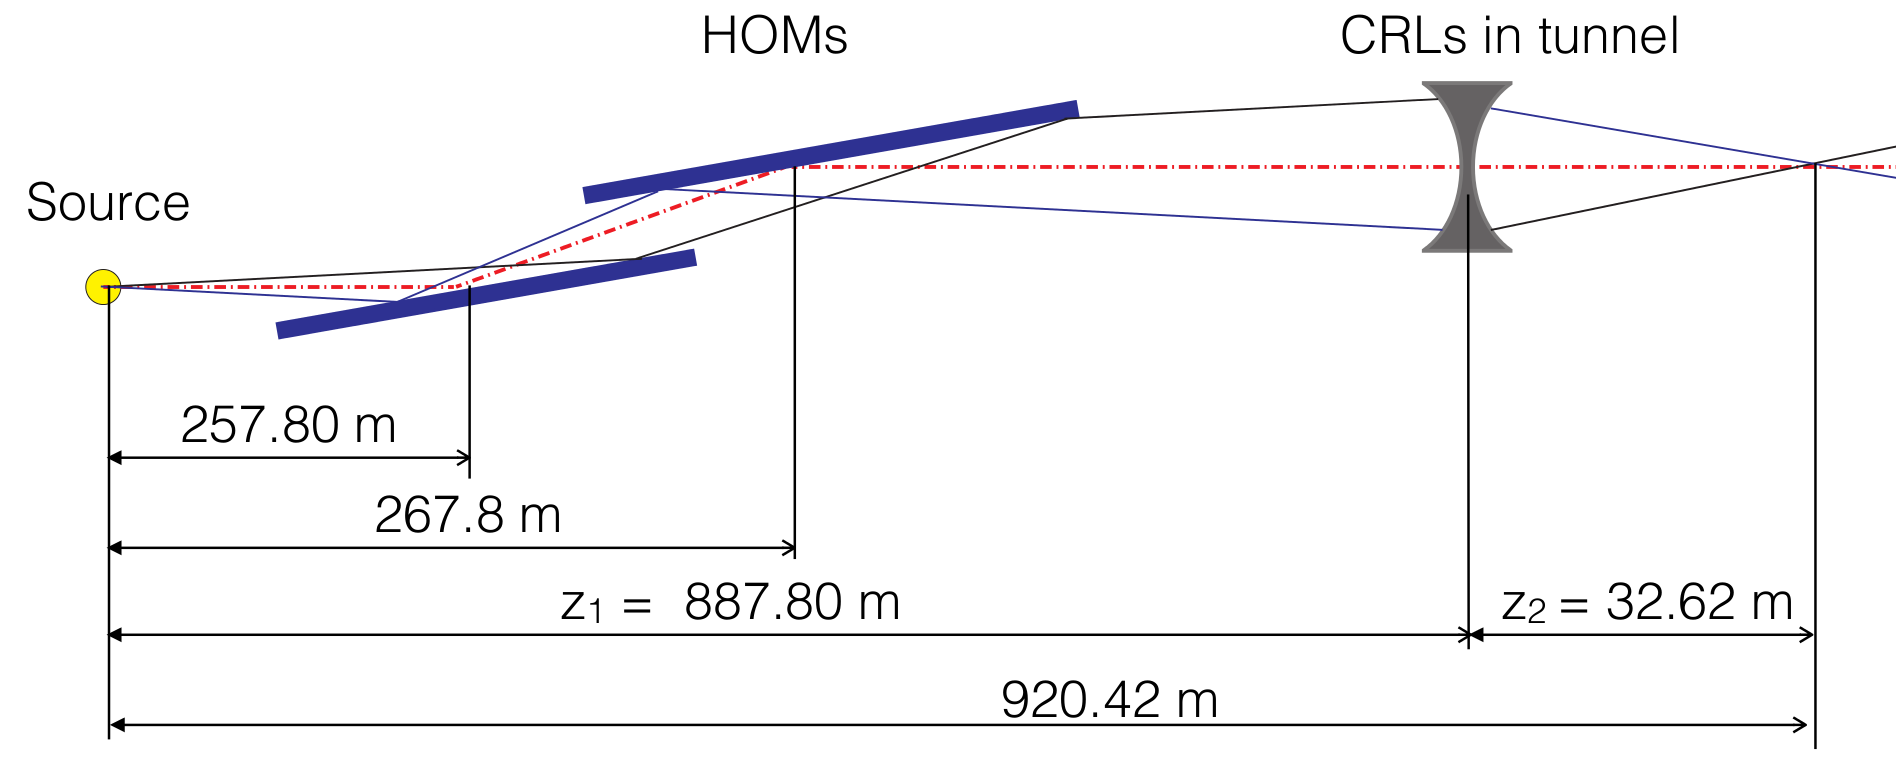

In [5]:
from IPython.display import Image
Image(filename='figures/spb_crl.png')

In [6]:
%%file tutorial3_beamline_focusing_CRL_disp.py

def get_beamline(z=None):
    import os
    import wpg
    from wpg import Beamline
    from wpg.optical_elements import Aperture, Drift, CRL, Empty, Use_PP, Mirror_plane, create_CRL_from_file
    from wpg.wpg_uti_oe import show_transmission
    import numpy as np

    wpg_path = os.path.abspath(os.path.dirname(wpg.__file__))
    data_path = 'data_wpg_tutorial_03'
    data_common_path = 'data_common'
    bPrint = False

    # S1 beamline layout
    # Geometry ###
    src_to_hom1 = 257.8  # Distance source to HOM 1 [m]
    src_to_hom2 = 267.8  # Distance source to HOM 2 [m]
    src_to_crl = 887.8   # Distance source to CRL [m]
    src_to_exp = 920.803  #920.42 # Distance source to experiment [m]
    if(z==None):
        z = 0
    
    theta_om = 3.6e-3  # [rad]

    om_mirror_length = 0.8  # [m]
    om_clear_ap = om_mirror_length * theta_om

    # define the beamline:
    bl0 = Beamline()

    # Define HOM1.
    aperture_x_to_y_ratio = 1
    hom1 = Aperture(
        shape='r', ap_or_ob='a', Dx=om_clear_ap, Dy=om_clear_ap / aperture_x_to_y_ratio)

    # Define mirror profile
    # Apply distortions.
    mirrors_path = os.path.join(wpg_path, '..','samples', 'data_common')
    hom1_wavefront_distortion = Mirror_plane(orient='x', 
                                             theta=theta_om, 
                                             length=om_mirror_length, 
                                             range_xy=om_clear_ap/aperture_x_to_y_ratio, 
                                             filename=os.path.join(mirrors_path, 'mirror1.dat'), 
                                             scale=1, delim=' ')
    if bPrint:
        print('HOM1 WF distortion'); show_transmission(hom1_wavefront_distortion);

    # Free space propagation from hom1 to hom2
    hom1_to_hom2_drift = Drift(src_to_hom2 - src_to_hom1)

    # Define HOM2 as aperture.
    hom2 = Aperture('r', 'a', om_clear_ap, om_clear_ap / aperture_x_to_y_ratio)

    # drift to CRL aperture
    hom2_to_crl_drift = Drift(src_to_crl - src_to_hom2)

    # Define CRL
    crl_focussing_plane = 3  # Both horizontal and vertical.
    # Refractive index decrement (n = 1- delta - i*beta)
    #crl_delta = 4.7967e-6           #<=8.43 keV 4.7177e-06
    #crl_attenuation_length = 6.1e-3 #<=8.43 keV 6.3e-3    # Attenuation length [m], Henke data.
    be_data = np.loadtxt(os.path.join(data_common_path,'be_8430ev.txt'))
    crl_delta = be_data[:,1]  # Dummy numbers)
    crl_attenuation_length  = be_data[:,2] #Dummy numbers)
    crl_shape = 1         # Parabolic lenses
    crl_aperture = 5.0e-3  # [m]
    crl_curvature_radius = 5.8e-3  # [m]
    crl_number_of_lenses = 19
    crl_wall_thickness = 8.0e-5  # Thickness
    crl_center_horizontal_coordinate = 0.0
    crl_center_vertical_coordinate = 0.0
    crl_initial_photon_energy = 8.42e3  # [eV] ### OK ???
    crl_final_photon_energy = 8.44e3  # [eV]   ### OK ???

    crl = create_CRL_from_file(data_path,
                     'opd_crl_n{:d}_r_{:d}_e_{:d}_{:d}ev'.format(crl_number_of_lenses,int(crl_curvature_radius*1e6),
                                                           int(crl_initial_photon_energy),int(crl_final_photon_energy)),
                     _foc_plane=crl_focussing_plane,
                     _delta=crl_delta,
                     _atten_len=crl_attenuation_length,
                     _shape=crl_shape,
                     _apert_h=crl_aperture,
                     _apert_v=crl_aperture,
                     _r_min=crl_curvature_radius,
                     _n=crl_number_of_lenses,
                     _wall_thick=crl_wall_thickness,
                     _xc=crl_center_horizontal_coordinate,
                     _yc=crl_center_vertical_coordinate,
                     _void_cen_rad=None,
                     _e_start=crl_initial_photon_energy,
                     _e_fin=crl_final_photon_energy
                    )
    if bPrint:
        print('CRL'); show_transmission(crl)

    # drift to sample including offset z
    crl_to_sample = Drift(src_to_exp - src_to_crl + z)
    # Beamline:
    bl0.append(
        hom1, Use_PP(semi_analytical_treatment=0))
    zoom = 1.2
    bl0.append(hom1_wavefront_distortion,
               Use_PP(semi_analytical_treatment=0, zoom=zoom, sampling=zoom/0.8))
    bl0.append(hom1_to_hom2_drift, Use_PP(semi_analytical_treatment=0))
    zoom = 1.0
    bl0.append(hom2, Use_PP(semi_analytical_treatment=0,
                            zoom=zoom, sampling=zoom / 0.75))
    bl0.append(hom2_to_crl_drift, Use_PP(semi_analytical_treatment=1))
    zoom = 0.6
    #bl0.append(
    #    crl, Use_PP(semi_analytical_treatment=1, zoom=zoom, sampling=zoom/0.1))
    bl0.append(
        crl, Use_PP(semi_analytical_treatment=1, zoom=zoom, sampling=zoom/0.9))
    bl0.append(crl_to_sample, Use_PP(semi_analytical_treatment=1))

    return bl0



Overwriting tutorial3_beamline_focusing_CRL_disp.py


### define source 

In [7]:
data_path = 'data_wpg_tutorial_03';mkdir_p(data_path)
out_prefix = 'gb_200as_'
src_oe1 = 257.8 # Distance to the first OE [m]
fname = '{0:s}at_{1:.0f}_m'.format(out_prefix,src_oe1);
bname = fname

# Central photon energy.
ekev = 8.43 # Energy [keV]

# Pulse parameters.
qnC = 0.1               # e-bunch charge, [nC]
pulse_duration = 9.e-15 # [s] <-is not used really, only ~coh time pulse duration has physical meaning 
pulseEnergy = 1.5e-3    # total pulse energy, J
coh_time = 0.2e-15      # [s]<-should be SASE coherence time, then spectrum will be the same as for SASE 
                        # check coherence time for 8 keV 0.5 nC SASE1

# Angular distribution
theta_fwhm = calculate_theta_fwhm_cdr_s1(ekev,qnC) # CDR2011 empirical formula
theta_fwhm = 3.2e-6 #empiric value for nzc 15 (linear SASE before saturation)
print('divergence FWHM {0:.1f} urad'.format(theta_fwhm*1e6))

divergence FWHM 3.2 urad


In [8]:
# Gaussian beam parameters
wlambda = 12.4*1e-10/ekev        # wavelength 
w0 = wlambda/(np.pi*theta_fwhm)  # FWHM beam waist; 
w0_a = w0/(2*np.sqrt(np.log(2))) # sigma of amplitude
zR = (np.pi*w0_a**2)/wlambda     # Rayleigh length, max WF curvature

# expected beam radius at OE1 position to get the range of the wavefront 
print('Intensity waist size: {:.0f} um FWHM'.format(w0*1e6))
print('Rayleigh length: {:.1f} m'.format(zR))
print('expected FWHM at distance {:.1f} m: {:.2f} mm'.format(src_oe1,theta_fwhm*src_oe1*1e3))

Intensity waist size: 15 um FWHM
Rayleigh length: 1.6 m
expected FWHM at distance 257.8 m: 0.82 mm


In [9]:
bSaved=True
sig_num = 5.5
num_points = 400 #number of points
range_xy = w0_a * np.sqrt(1+(src_oe1/zR)**2)/np.sqrt(2)*sig_num;
print('range_xy at OE1: {:.1f} mm'.format(range_xy*1e3))
dx = 10.e-6; range_xy = dx*(num_points-1);
print('range_xy at OE1: {:.1f} mm'.format(range_xy*1e3))
nslices = 20; 

range_xy at OE1: 5.3 mm
range_xy at OE1: 4.0 mm


### create Gaussian beam

In [10]:
srwl_wf = build_gauss_wavefront(num_points, num_points, nslices, ekev, -range_xy/2, range_xy/2,
                                -range_xy/2, range_xy/2 ,coh_time/np.sqrt(2), 
                                w0_a, w0_a, src_oe1,
                                pulseEn=pulseEnergy, pulseRange=8.)
wf = Wavefront(srwl_wf)
z0 = src_oe1
#defining name HDF5 file for storing wavefront
#store wavefront to HDF5 file 
if bSaved:     
    wf.store_hdf5(os.path.join(data_path,fname+'.h5')); 
    print('saving WF to {:s}'.format(os.path.join(data_path,fname+'.h5')))

xx=calculate_fwhm(wf);
print('FWHM at distance {:.1f} m: {:.2f} x {:.2f} mm2'.format(z0,xx[u'fwhm_x']*1e3,xx[u'fwhm_y']*1e3));

saving WF to data_wpg_tutorial_03/gb_200as_at_258_m.h5
FWHM at distance 257.8 m: 0.80 x 0.80 mm2


### show Gaussian wavefront in R- and Q-space

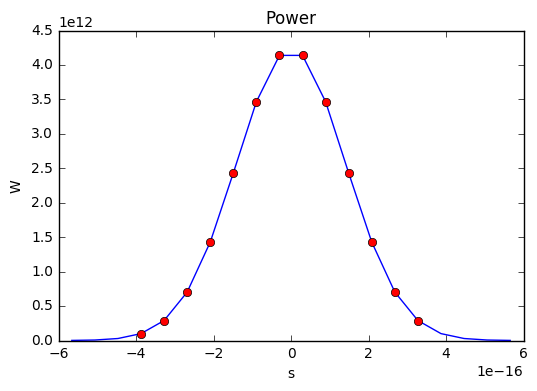

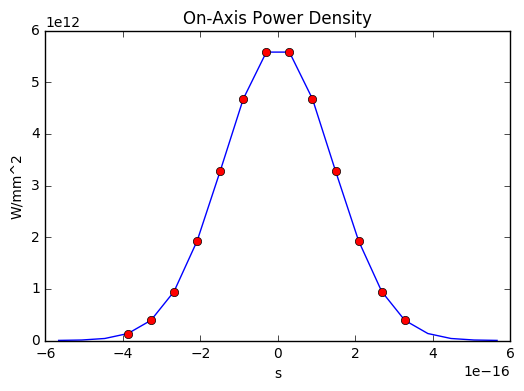

number of meaningful slices: 13
Pulse energy 1.4896 mJ
R-space
(400,) (400,)


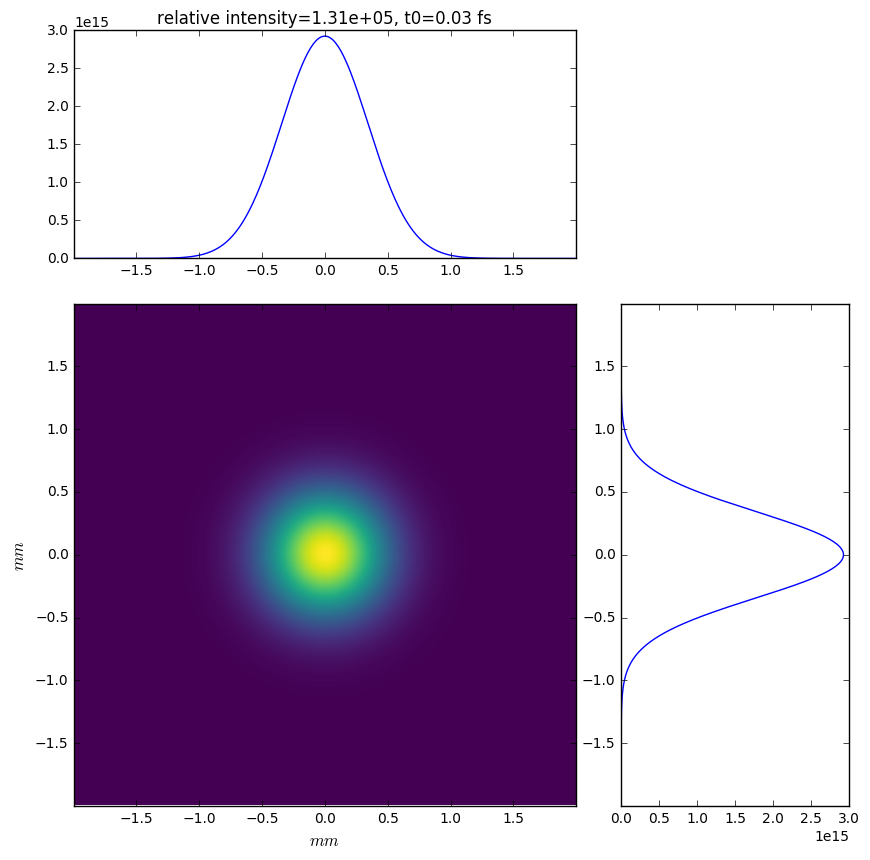

Q-space
{'fwhm_y': 3.1154125889679717e-06, 'fwhm_x': 3.1154125889679717e-06}
Q-space
(400,) (400,)


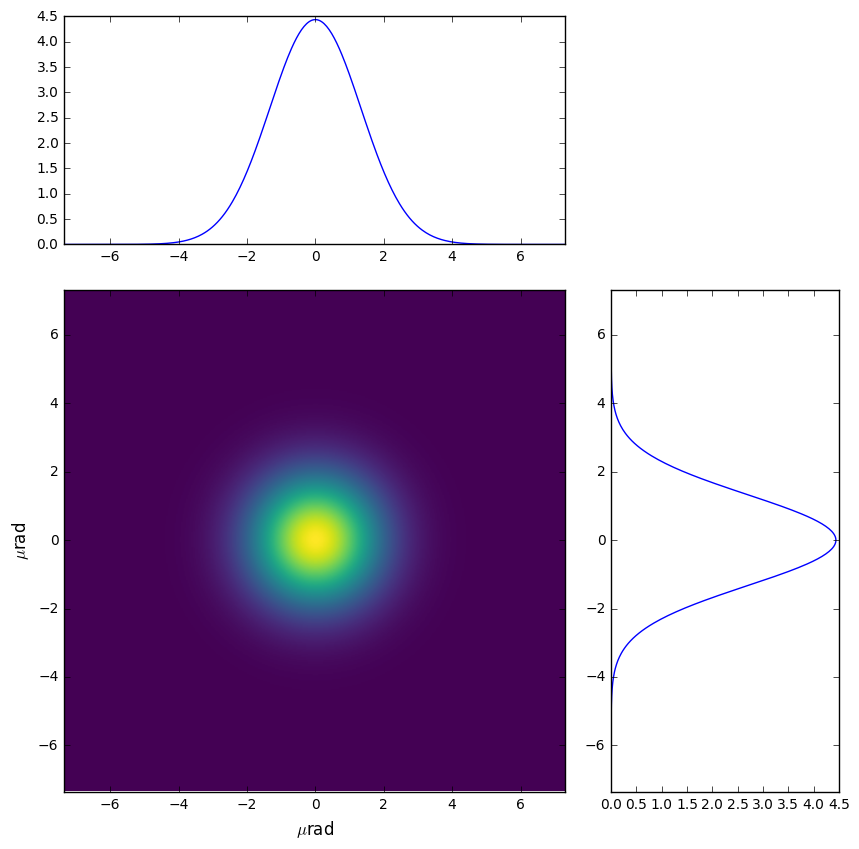

In [11]:
plot_wf(wf)
look_at_q_space(wf)

### propagate through the beamline

Found file data_wpg_tutorial_03/opd_crl_n19_r_5800_e_8420_8440ev.pkl. CLR will be loaded from file
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.00288
	Dy = 0.00288
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.2, 1.4999999999999998, 1.2, 1.4999999999999998, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 300000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1500
		ny = 100
		xFin = 0.00144
		xStart = -0.00144
		yFin = 0.00144
		yStart = -0.00144
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 10.0
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.3333333333333333, 1.0, 1.3333333333333333, 0, 0, 0]
	Dx = 0.00288
	Dy = 0

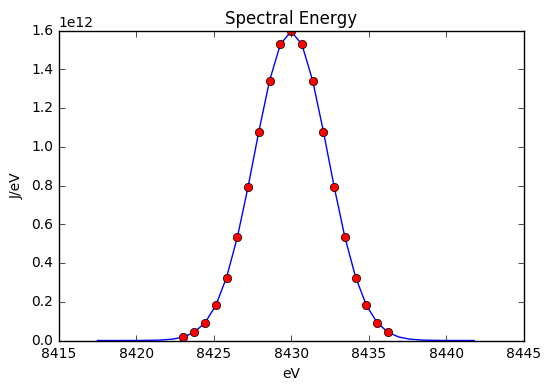

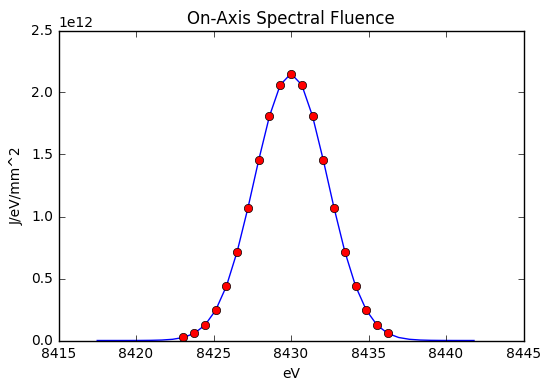

number of meaningful slices: 20
R-space
(400,) (400,)


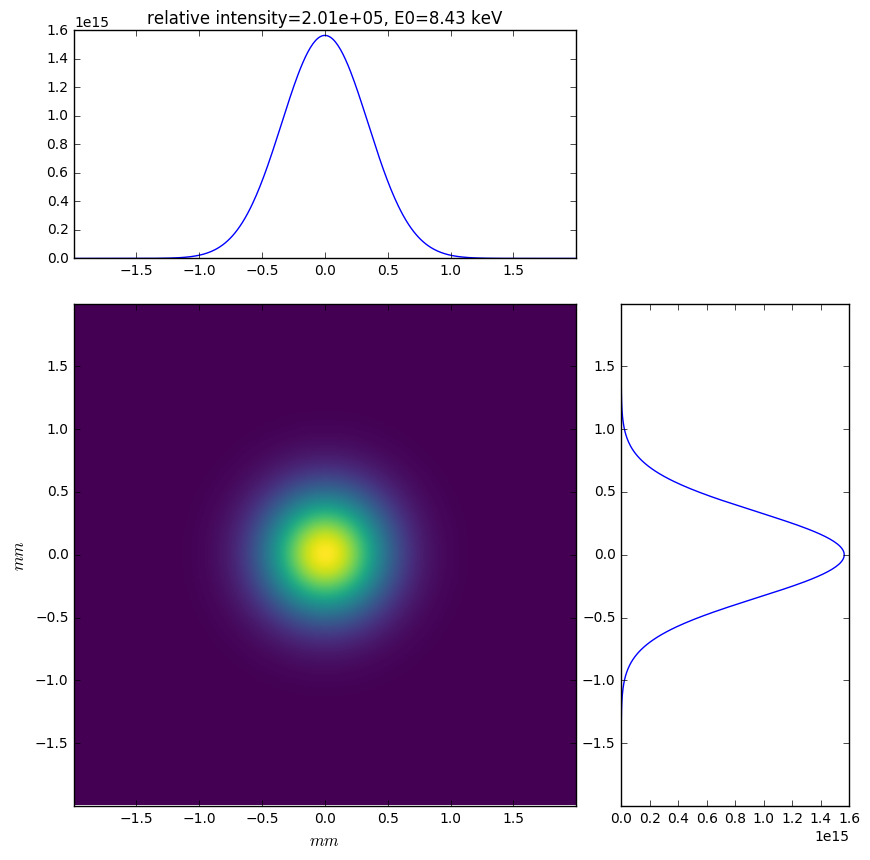

propagating WF...
in 112.58 s


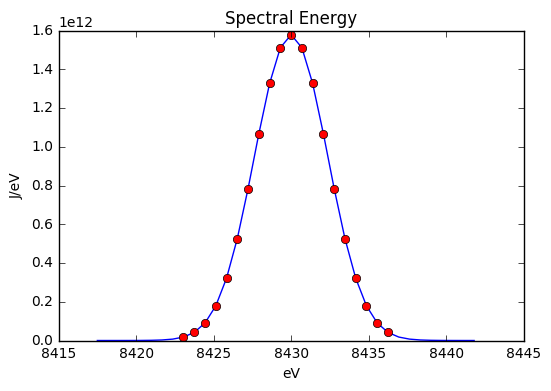

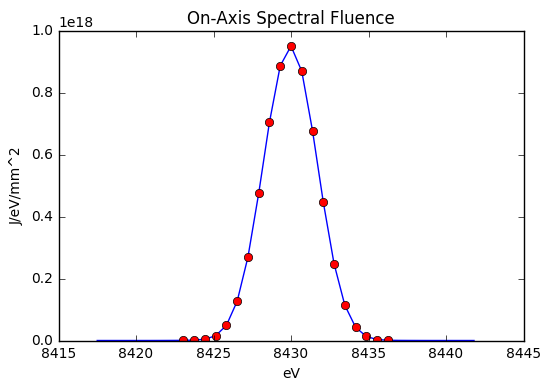

number of meaningful slices: 20
R-space
(384,) (384,)


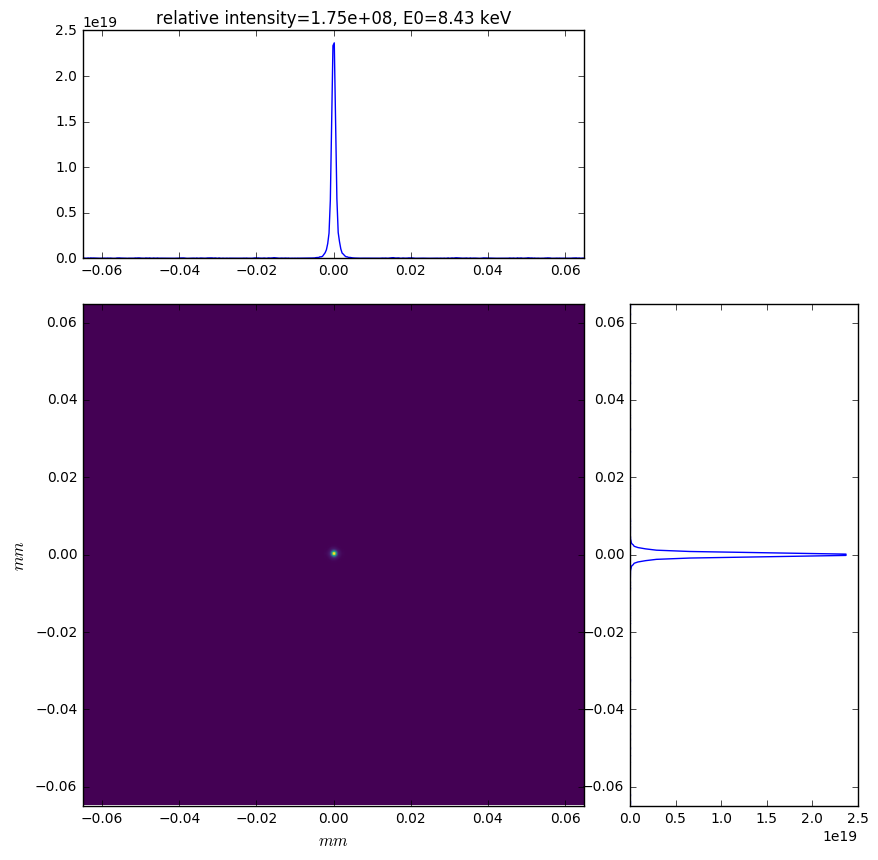

increasing range in frequency domain...
 done in 1.97 s
switching in time domain...
done in 1.41 s
resizing after propagation...
done in 3.42 s
FWHM at 0.0 mm offset: 1.35 x 1.35 um2


In [12]:
#loading beamline from file
import imp
custom_beamline = imp.load_source('custom_beamline', 'tutorial3_beamline_focusing_CRL_disp.py')
get_beamline = custom_beamline.get_beamline
#za = np.array([-30.e-3,-25.e-3,-20e-3,-15.e-3,-10.e-3])
za = np.array([0.])
fwhm_x = np.zeros(len(za), dtype='float32')
fwhm_y = np.zeros(len(za), dtype='float32')
for idx in range (len(za)):
    z = za[idx]
    bl = get_beamline(z)
    if idx==0: print(bl)
    wf=Wavefront() ;wf.load_hdf5(os.path.join(data_path,fname+'.h5'))
    srwl.ResizeElecField(wf._srwl_wf, 't', [0, 5, 1]);
    print('switching in frequency domain...');t0 = time.time();
    srwl.SetRepresElecField(wf._srwl_wf, 'f') # <---- switch to frequency domain
    print('done in {:.2f} s'.format(time.time()-t0))
    print('decreasing range in frequency domain...');t0 = time.time();
    srwl.ResizeElecField(wf._srwl_wf, 'f', [0, 0.33, 1.]);print('done in {:.2f} s'.format(time.time()-t0))
    plot_wf(wf)
    print('propagating WF...');t0 = time.time();
    bl.propagate(wf); print('in {:.2f} s'.format(time.time()-t0))
    plot_wf(wf)
    print('increasing range in frequency domain...');t0 = time.time();
    srwl.ResizeElecField(wf._srwl_wf, 'f', [0, 3., 1.]); print(' done in {:.2f} s'.format(time.time()-t0))
    print('switching in time domain...');t0 = time.time();
    srwl.SetRepresElecField(wf._srwl_wf, 't'); print('done in {:.2f} s'.format(time.time()-t0))
    print('resizing after propagation...');t0 = time.time();
    srwl.ResizeElecField(wf._srwl_wf, 't', [0, 0.6, 1]); print('done in {:.2f} s'.format(time.time()-t0))
    #plot_wf(wf)
    xx=calculate_fwhm(wf);
    print('FWHM at {:.1f} mm offset: {:.2f} x {:.2f} um2'.format(z*1e3, xx[u'fwhm_x']*1e6,xx[u'fwhm_y']*1e6));
    fwhm_x[idx] = xx[u'fwhm_x'];fwhm_y[idx] = xx[u'fwhm_y'];
    #plot_wf(wf)

### show propagated wavefront

FWHM propagated beam: 1.35 x 1.35 um2


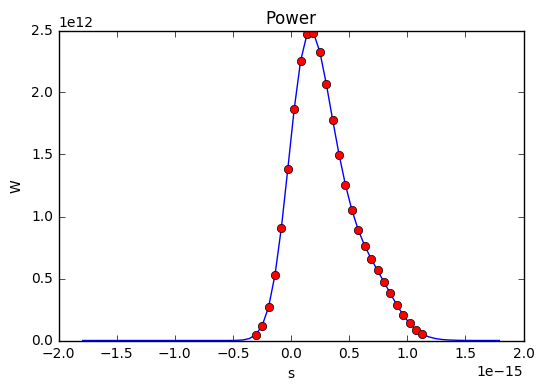

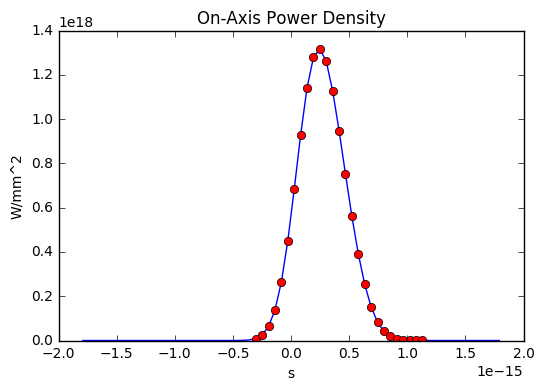

number of meaningful slices: 27
Pulse energy 1.4786 mJ
R-space
(384,) (384,)


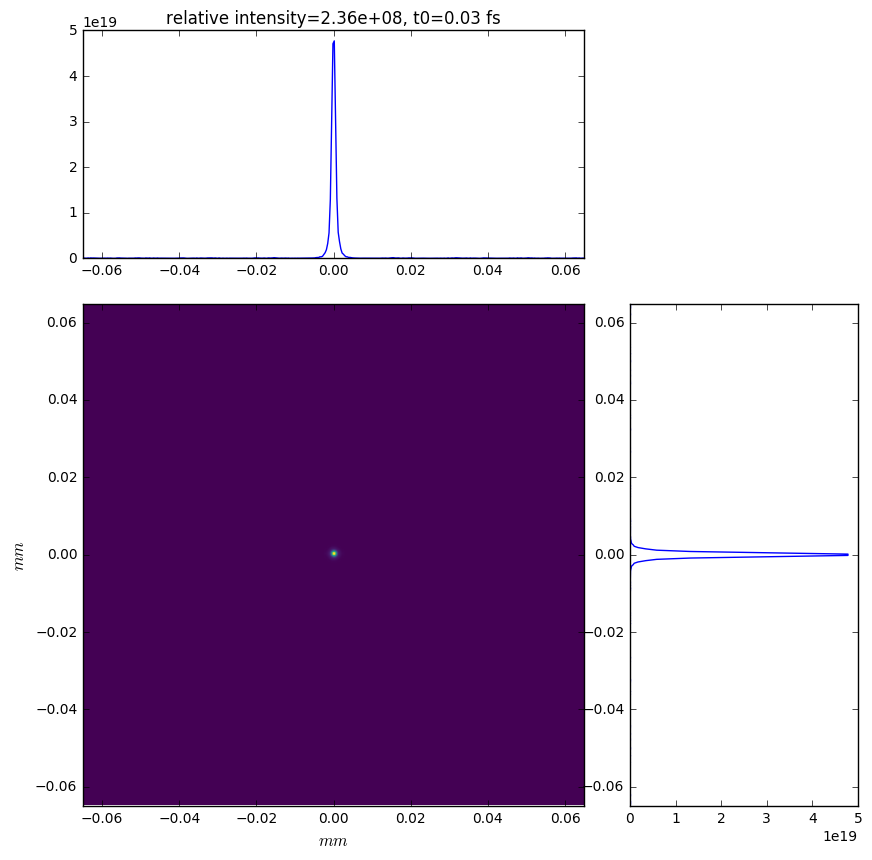

Q-space
{'fwhm_y': 9.135004824425227e-05, 'fwhm_x': 8.997153828392896e-05}
Q-space
(384,) (384,)


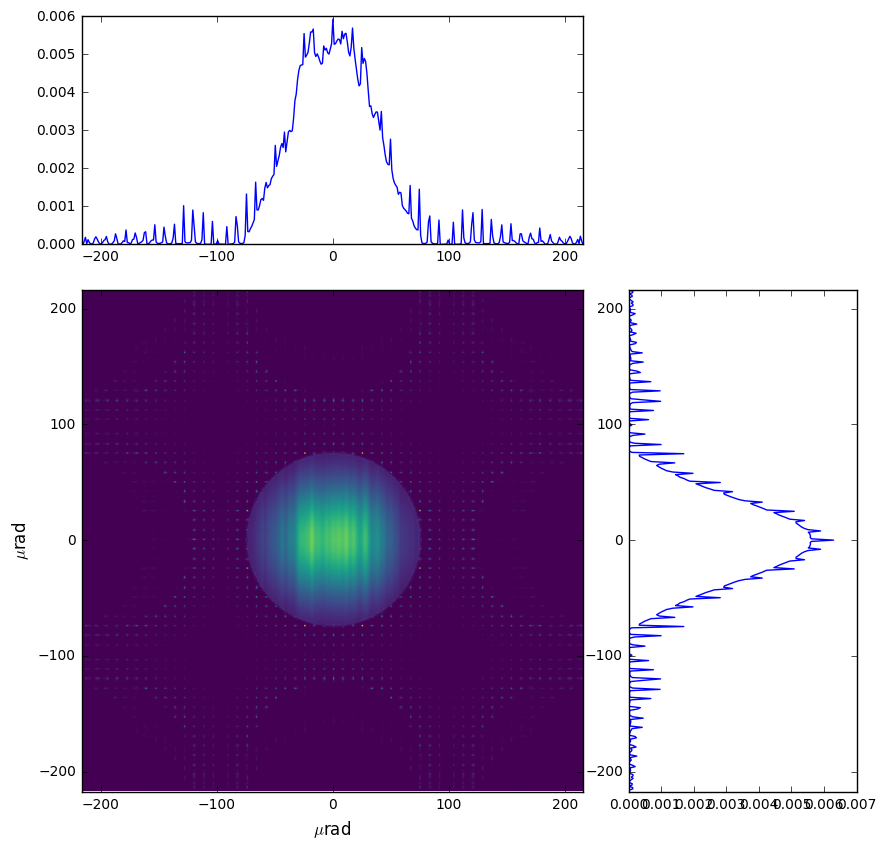

In [13]:
xx=calculate_fwhm(wf);
print('FWHM propagated beam: {:.2f} x {:.2f} um2'.format(xx[u'fwhm_x']*1e6,xx[u'fwhm_y']*1e6));
plot_wf(wf)
look_at_q_space(wf)    

### save propagated pulse 

In [14]:
z = src_to_exp
fname = '{:s}_disp_prop_at_{:03d}m'.format(bname,int(np.floor(z)))
if bSaved:     
    wf.store_hdf5(os.path.join(data_path,fname+'.h5')); 
    print('saving WF to {:s}'.format(os.path.join(data_path,fname+'.h5')))


saving WF to data_wpg_tutorial_03/gb_200as_at_258_m_prop_at_921m.h5


### load FEL SASE pulse 
**copy FEL pulse**   `s1_8_43_100_xy75_ss14_nzc15_1_0000001_prop_at_256m.h5`   from **tutorial1 data folder**

source size FWHM: 0.812 x 0.813 mm2


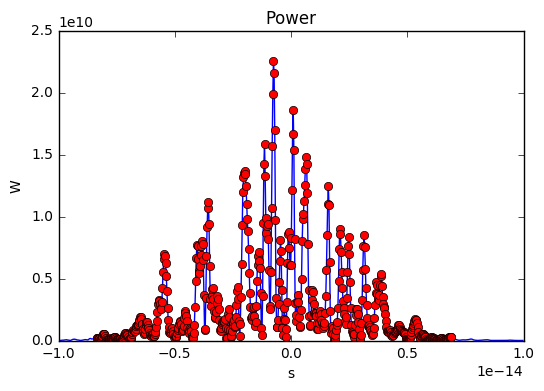

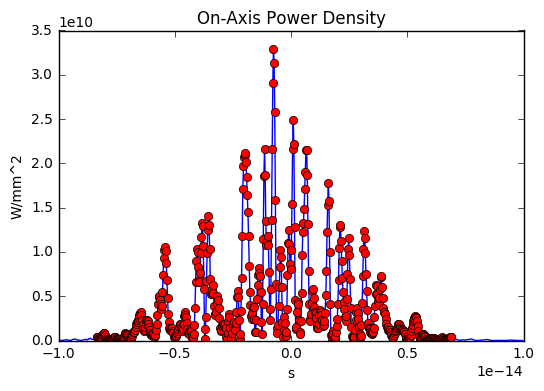

number of meaningful slices: 557
Pulse energy 0.0434 mJ
R-space
(286,) (286,)


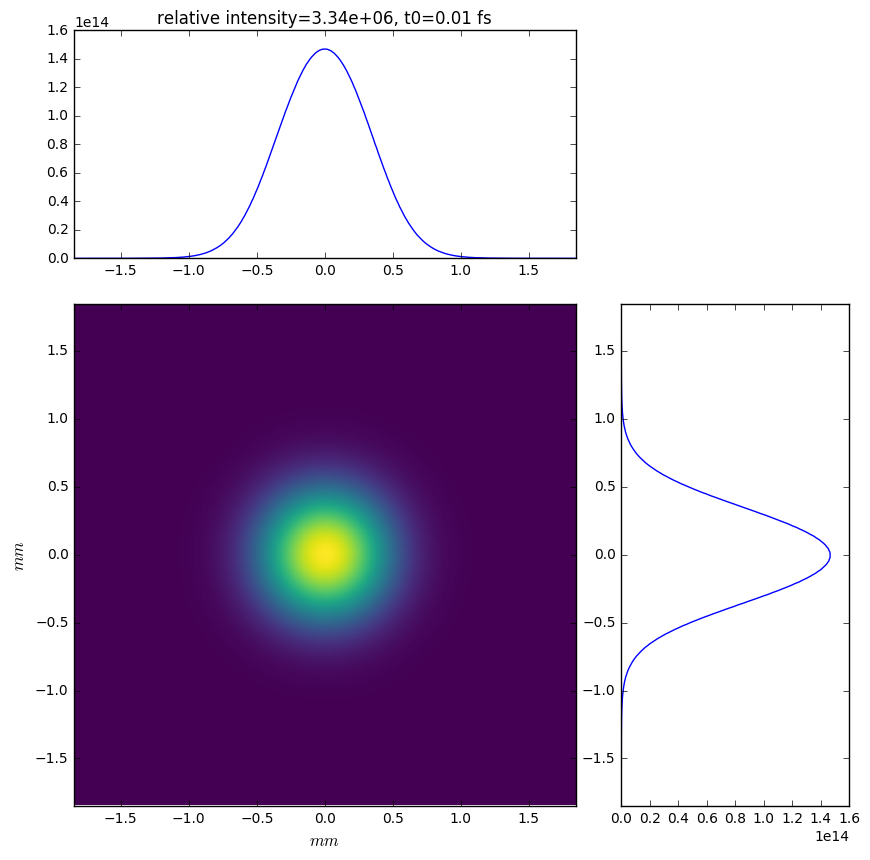

Q-space
{'fwhm_y': 3.081152098921234e-06, 'fwhm_x': 3.0862013654761595e-06}
Q-space
(286,) (286,)


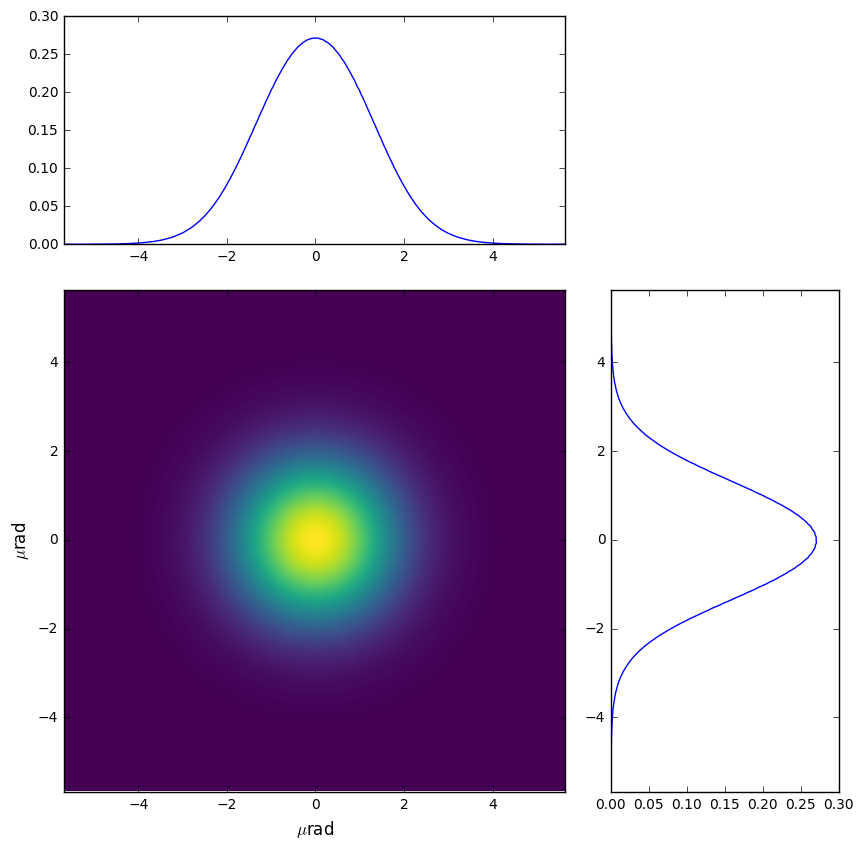

Found file data_wpg_tutorial_03/opd_crl_n19_r_5800_e_8420_8440ev.pkl. CLR will be loaded from file
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.00288
	Dy = 0.00288
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.2, 1.4999999999999998, 1.2, 1.4999999999999998, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 300000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1500
		ny = 100
		xFin = 0.00144
		xStart = -0.00144
		yFin = 0.00144
		yStart = -0.00144
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 10.0
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.3333333333333333, 1.0, 1.3333333333333333, 0, 0, 0]
	Dx = 0.00288
	Dy = 0

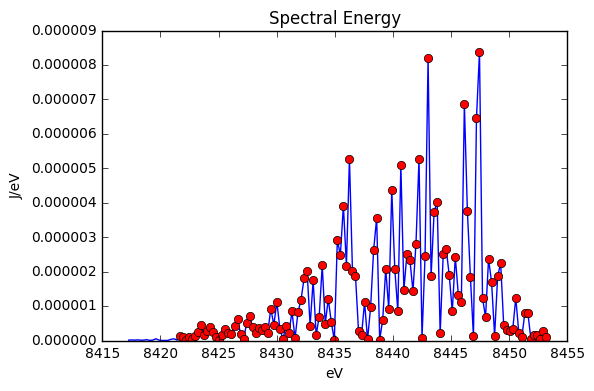

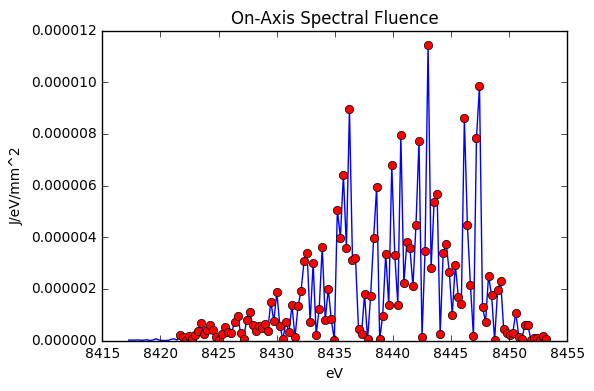

number of meaningful slices: 122
R-space
(286,) (286,)


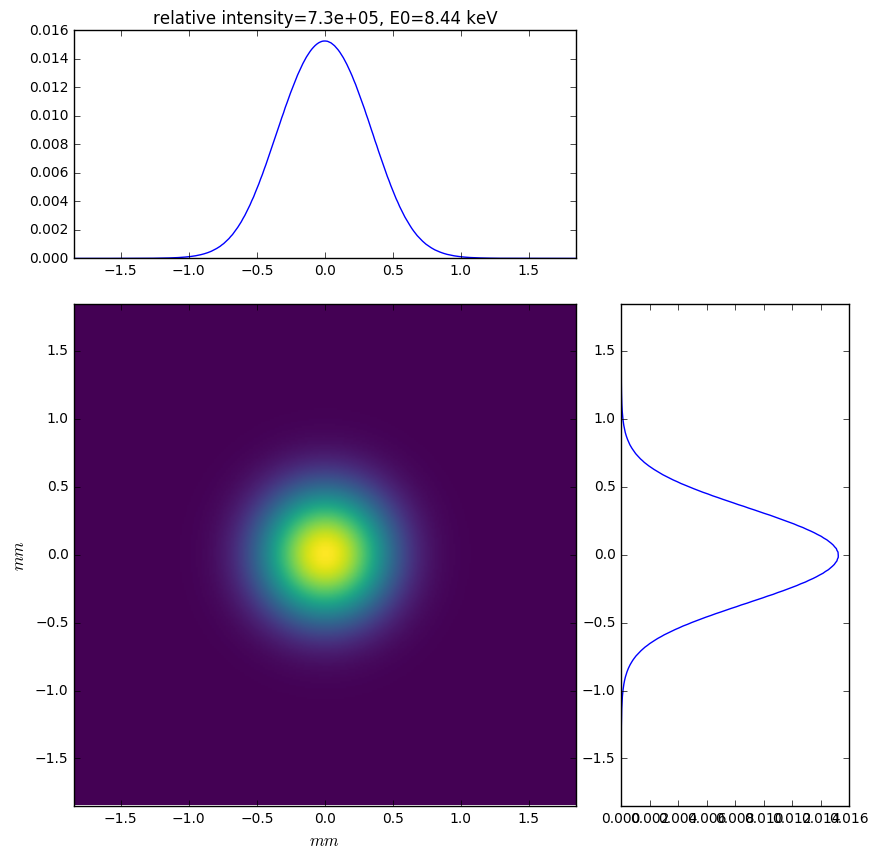

propagating WF...


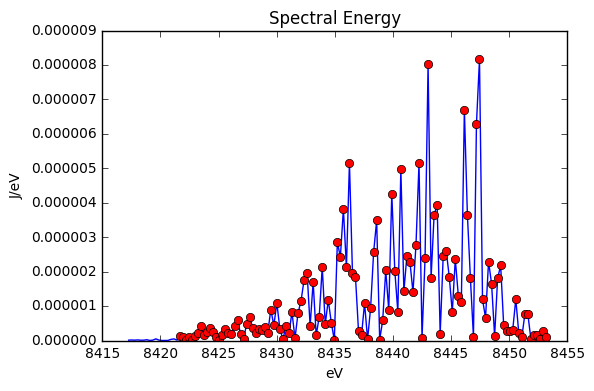

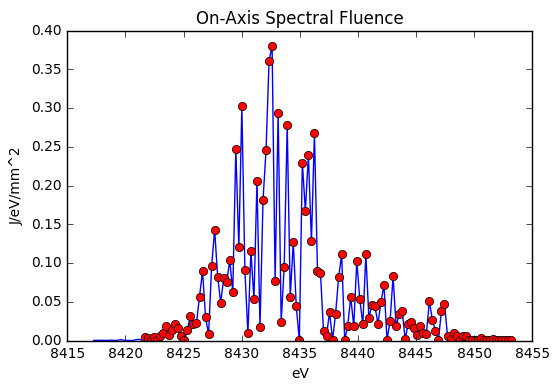

number of meaningful slices: 122
R-space
(280,) (280,)


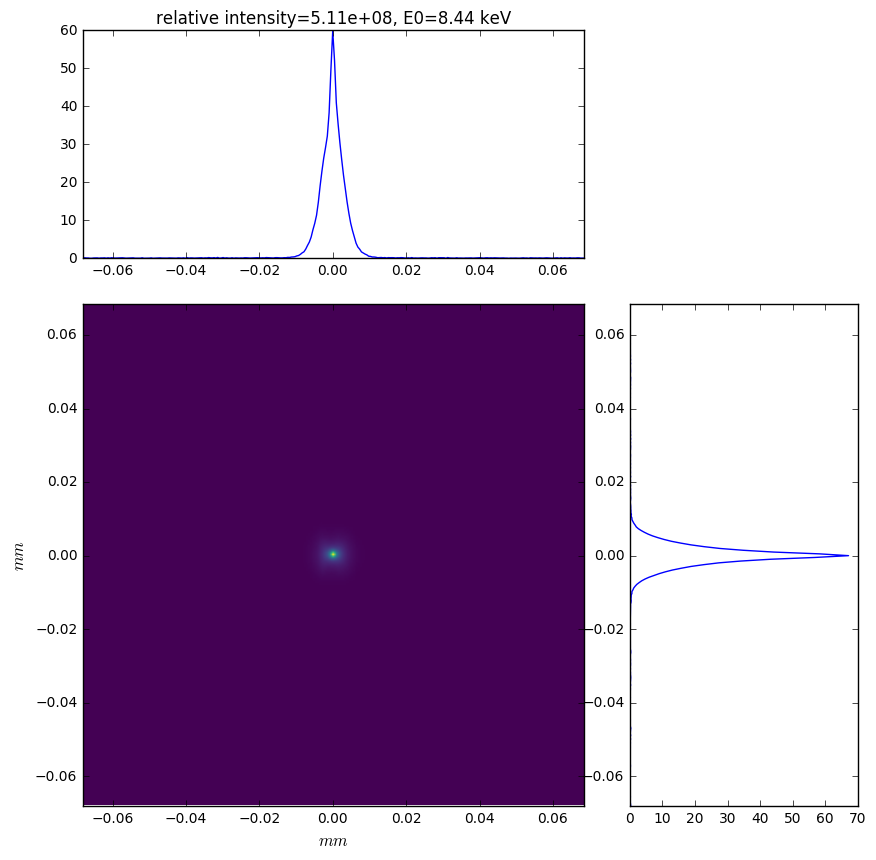

increasing range in frequency domain...
 done in 7.32 s
switching in time domain...
done in 25.22 s
resizing after propagation...
done in 24.54 s
FWHM propagated beam: 1.46 x 1.46 um2


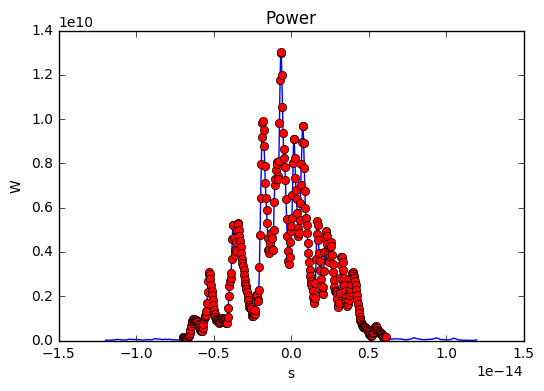

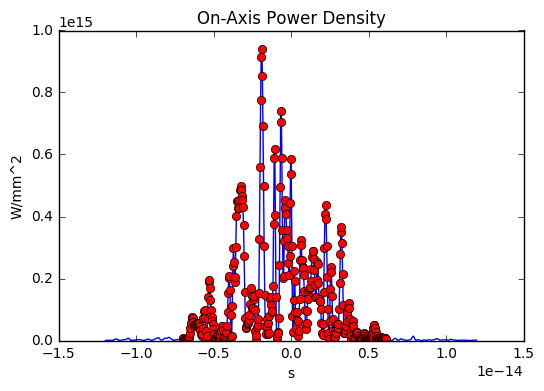

number of meaningful slices: 345
Pulse energy 0.0407 mJ
R-space
(280,) (280,)


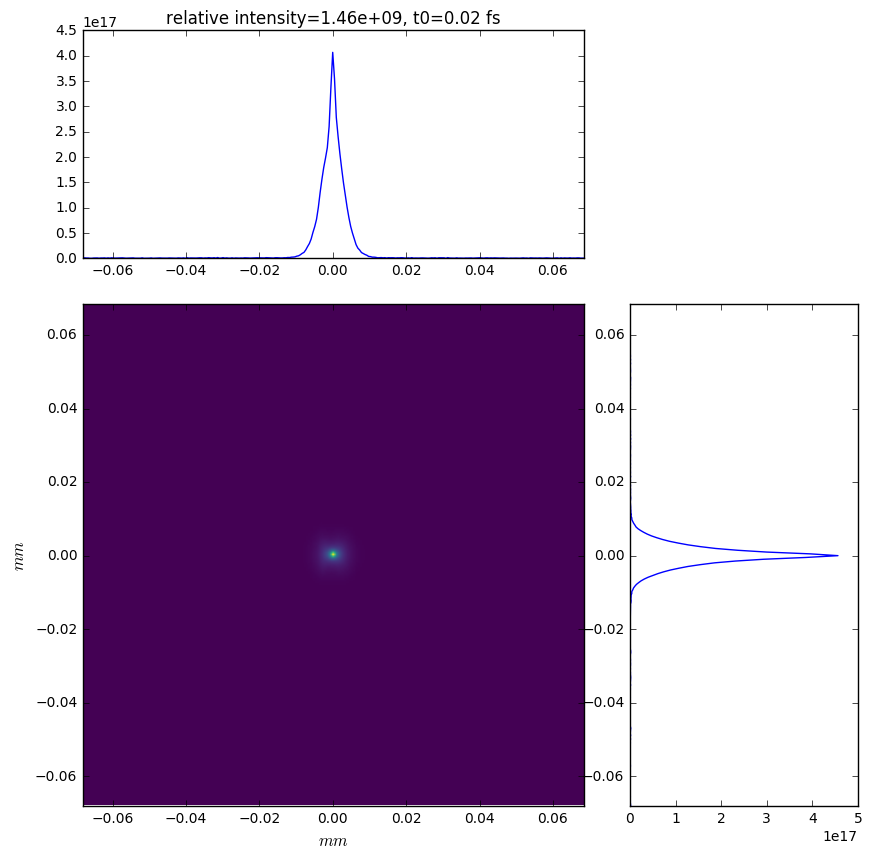

Q-space
{'fwhm_y': 8.553356368436692e-05, 'fwhm_x': 8.429972659729668e-05}
Q-space
(280,) (280,)


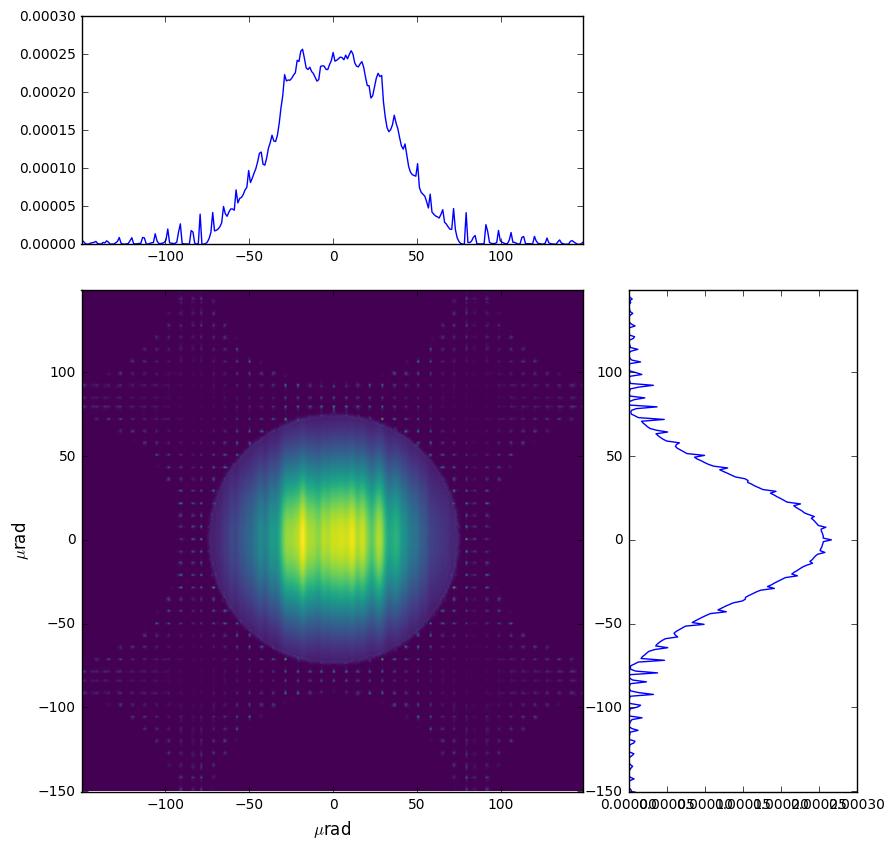

In [15]:
wf=Wavefront()
bname = 's1_8_43_100_xy75_ss14_nzc15_1_0000001'
fname = bname+'_prop_at_256m'
wf.load_hdf5(os.path.join(data_path,fname+'.h5'))
#plot_wf(wf)
#look_at_q_space(wf)

### show initial FEL SASE wavefront

from wpg.srwlib import srwl
#Resizing: decreasing Range of Horizontal and Vertical Position:
#srwl.ResizeElecField(wf._srwl_wf, 'c', [0, 0.48, 0.48/0.16, 0.48,  0.48/0.16]);
xx=calculate_fwhm(wf);
print('source size FWHM: {:.3f} x {:.3f} mm2'.format(xx[u'fwhm_x']*1e3,xx[u'fwhm_y']*1e3));
plot_wf(wf)
look_at_q_space(wf)    
#wpg.srwlib.srwl.SetRepresElecField(wf._srwl_wf, 'f')

### propagate through the beamline

#loading beamline from file
import imp
custom_beamline = imp.load_source('custom_beamline', 'tutorial3_beamline_focusing_CRL_disp.py')
get_beamline = custom_beamline.get_beamline
bl = get_beamline(0.)
print(bl)

srwl.ResizeElecField(wf._srwl_wf, 't', [0, 5, 1]);
print('switching in frequency domain...');t0 = time.time();
srwl.SetRepresElecField(wf._srwl_wf, 'f') # <---- switch to frequency domain
print('done in {:.2f} s'.format(time.time()-t0))
print('decreasing range in frequency domain...');t0 = time.time();
srwl.ResizeElecField(wf._srwl_wf, 'f', [0, 0.24, 0.24/1.5]);print('done in {:.2f} s'.format(time.time()-t0))
plot_wf(wf)
print('propagating WF...');t0 = time.time();
bl.propagate(wf)
plot_wf(wf)
print('increasing range in frequency domain...');t0 = time.time();
srwl.ResizeElecField(wf._srwl_wf, 'f', [0, 3., 3./0.6]); print(' done in {:.2f} s'.format(time.time()-t0))
print('switching in time domain...');t0 = time.time();
srwl.SetRepresElecField(wf._srwl_wf, 't'); print('done in {:.2f} s'.format(time.time()-t0))
print('resizing after propagation...');t0 = time.time();
srwl.ResizeElecField(wf._srwl_wf, 't', [0, 0.3, 1]); print('done in {:.2f} s'.format(time.time()-t0))

### show propagated wavefront
xx=calculate_fwhm(wf);
print('FWHM propagated beam: {:.2f} x {:.2f} um2'.format(xx[u'fwhm_x']*1e6,xx[u'fwhm_y']*1e6));
plot_wf(wf)
look_at_q_space(wf)    

In [17]:
src_to_exp = 920.803 # distance source to imager 
z = src_to_exp
fname_out = '{:s}_disp_prop_at_{:03d}m'.format(bname,int(np.floor(z)))
if bSaved:     
    print('saving WF to {:s}'.format(os.path.join(data_path,fname_out+'.h5')))
    wf.store_hdf5(os.path.join(data_path,fname_out+'.h5')); 
def add_history(wf_file_name, history_file_name):
    """
    Add history from pearent file to propagated file
    
    :param wf_file_name: output file
    :param history_file_name: peraent file
    """
    import h5py
    with h5py.File(wf_file_name) as wf_h5:
        with h5py.File(history_file_name) as history_h5:
            if 'history' in wf_h5:
                del wf_h5['history']
            
            wf_h5.create_group('/history/parent/')
            wf_h5.create_group('/history/parent/detail')
            
            for k in history_h5:
                if k=='history':
                    try:
                        history_h5.copy('/history/parent', wf_h5['history']['parent'])
                    except KeyError:
                        pass
                        
                elif not k == 'data':
                    history_h5.copy(k,wf_h5['history']['parent']['detail'])
                else:
                    wf_h5['history']['parent']['detail']['data'] = h5py.ExternalLink(history_file_name,'/data')

add_history(os.path.join(data_path,fname_out+'.h5'), os.path.join(data_path,fname+'.h5'))

saving WF to data_wpg_tutorial_03/s1_8_43_100_xy75_ss14_nzc15_1_0000001_disp_prop_at_920m.h5
